In [16]:
!nvidia-smi

Thu Aug  4 22:24:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P3    N/A /  N/A |    359MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

In [18]:
!python3 -c 'import tensorflow as tf; print("Number of GPU : ",tf.config.list_physical_devices("GPU")) '

/mnt/drive1/anaconda3/envs/tfgoogle/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of GPU :  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [19]:
!python3 -c 'import torch as tc; print("GPU available : ", tc.cuda.is_available())'

GPU available :  True


In [20]:
!pwd && cd /mnt/drive1/ 

/mnt/drive1/Joint-Sentence-Classification-by-Neural-Networks


In [21]:
! cd /mnt/drive1/Joint-Sentence-Classification-by-Neural-Networks

NLP problems are classified as sequence problems in the real worlds because the AI in
uses word embeddings or vectorised word to train on real world data and then classify textual matters

There are various types of sequence problems

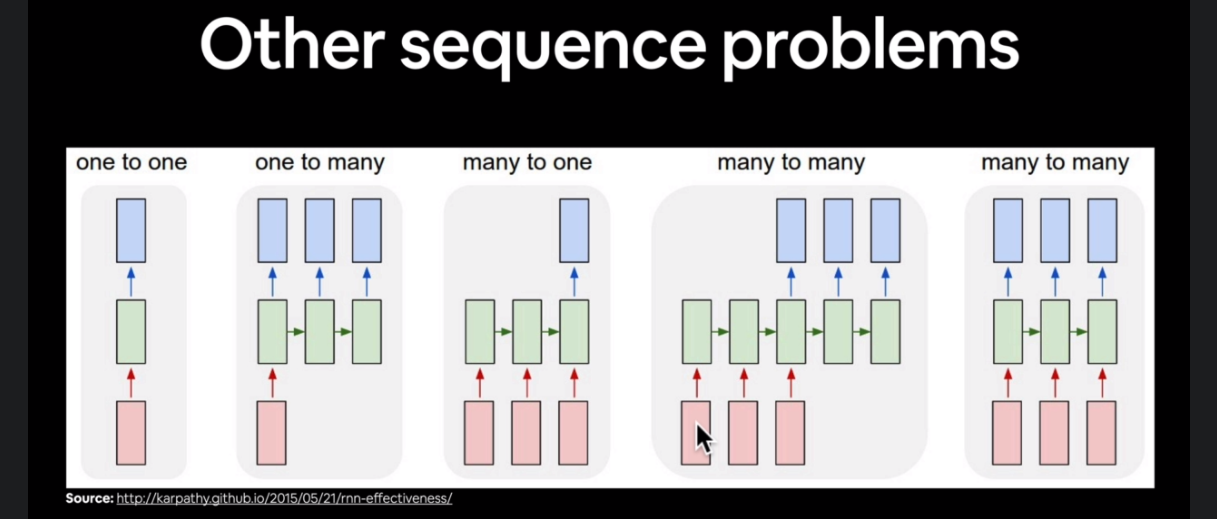

Examples of some sequence problems

1.  Many to one - Sentiment Analysis like analysing comments on youtube section,Time series forecasting (like predicting the prices of Bitcoin)
2.  One to many - Image Captioning [Passing on an image and the resuly maybe a whole captioned images]
3.  Many to many - Google translate

# Todo update list
1. Dataset preprocessing
2. Tokenization and embedding
3. RNN/CNN/Transfer-learning model setups
4. External model from Tfhub
5. Evaluation of the models
6. Prediction on custom data



# Inputs and outputs to an NLP problem statement
The inputs to an NLP problem is that a sequence of words are passed for example lets take an example of fake news related tweets classification , in this problem the tweets wold get numerical encoded which forms the input in a NLP model, because a Machine learning algorithm prefers values between 0 and 1 so it gets encoded in those ranges by tokenization and Character embedding . The output for this problem would be in probabilities like how much chance is there that it is a fake or how much chance is there
that it is real.

In simpler words what the machine basically uses is the #BATCH SIZE and the #Embedding_size [these vary as per the problem statement that we are handling].Batch size is basically partitioning the data into batches because for deep learning we need a GPU, and a GPU likes to work on batches on data rather than passing the dataset in one whole go.The embedding size is the size of the tensor because the tweet would be represented as tensor.And the ouputs would be the shape of the output tensor which is equal to the nos of classes the data is getting classified into like 2, 3, 4 ,5. In this case it's getting classified as 2 types like fake or real[this also varies as per your problem statement].

# Steps in modelling in Tensorflow
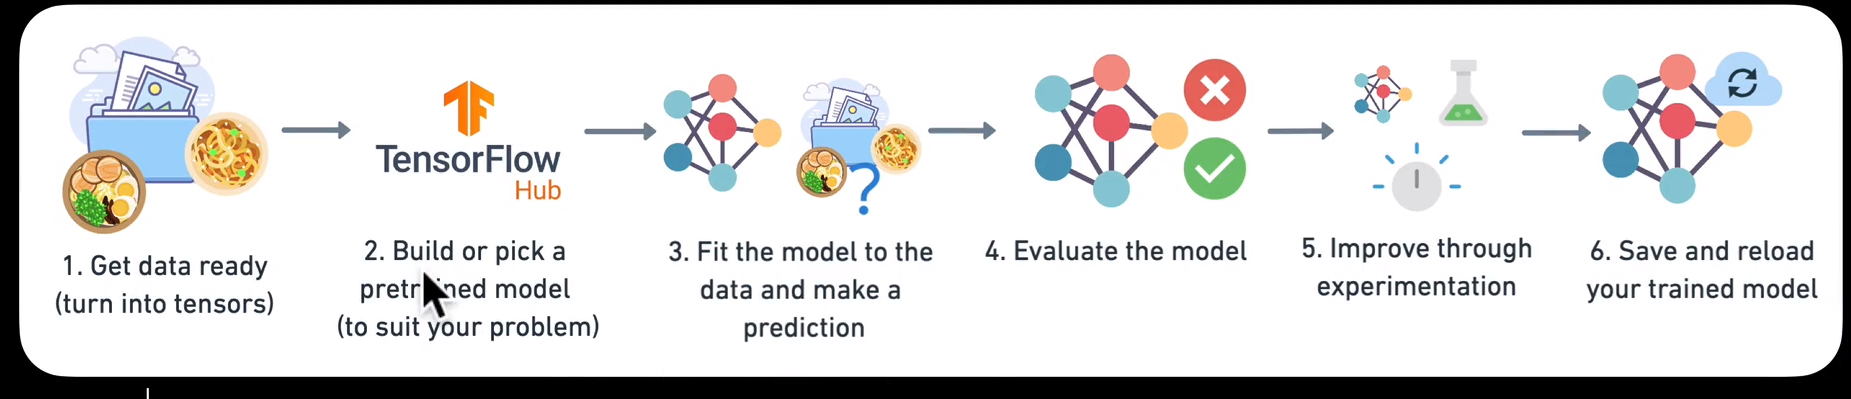

# Typical Architecture of Recurrent neural network

A recurrent neural network (RNN) is a class of artificial neural networks
where connections between nodes form a directed 
or undirected graph along a temporal sequence.

Basically it works on data with a temporal sequence that means a data which has a start 
and a end [Time series problem]

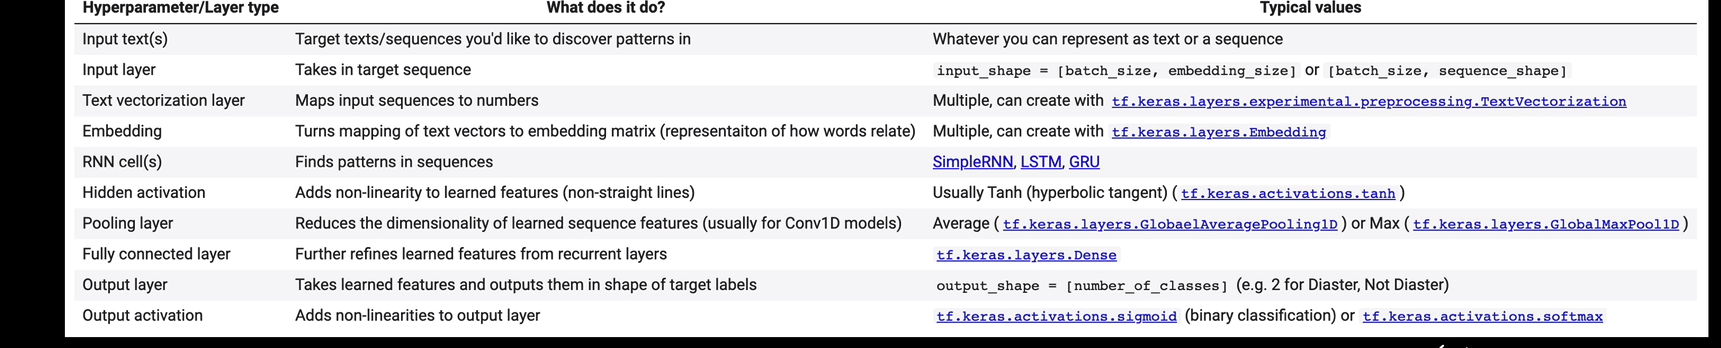



In [23]:
# My custom helper functions
!wget https://raw.githubusercontent.com/Purbayan2014/Tensorflow-prac-scripts/master/Transfer-learning/Fine-Tuning/utils.py

--2022-08-04 22:24:28--  https://raw.githubusercontent.com/Purbayan2014/Tensorflow-prac-scripts/master/Transfer-learning/Fine-Tuning/utils.py
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6262 (6.1K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   6.12K  --.-KB/s    in 0.002s  

2022-08-04 22:24:28 (3.39 MB/s) - ‘utils.py’ saved [6262/6262]



In [44]:
# Libraries used
import tensorflow as tf
from tensorflow.keras import layers,Model
from tensorflow.keras.layers import Input,LSTM,Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from utils import loss_plotter,image_preprocessor,pretty_matrix,pred_image_plt_plot,create_tensorboard_callback,histor_cmp,unzip_data,walker_dt_dir,evaluate_bin_class_model
from sklearn.model_selection import train_test_split
import pandas as pd
import random

In [29]:
# getting the dataset [kaggle's introduction to NLP dataset] binary classification
!ls -la

total 2624
drwxr-xr-x  5 markins markins    4096 Aug  4 22:32 .
drwxrwxrwx 67 markins markins    4096 Aug  4 11:35 ..
drwxr-xr-x  8 markins markins    4096 Aug  4 08:40 .git
drwxr-xr-x  2 markins markins    4096 Aug  4 21:02 .ipynb_checkpoints
-rw-r--r--  1 markins markins 1239923 Aug  4 22:32 NLP-reference-notes.ipynb
drwxr-xr-x  2 markins markins    4096 Aug  4 22:25 __pycache__
-rw-r--r--  1 markins markins      50 Aug  4 08:40 README.md
-rw-r--r--  1 markins markins  420783 Aug  4 22:30 test.csv
-rw-r--r--  1 markins markins  987712 Aug  4 22:31 train.csv
-rw-r--r--  1 markins markins    6262 Aug  4 22:24 utils.py


In [31]:
# Visualizing the dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [32]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [33]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [34]:
# TEXT is the tweets and the targets are the labels
# 1 is for disaster and 0 is for safe

# shuffling the dataset
train_df_sf = train_df.sample(frac=1,random_state=42)
train_df_sf.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [36]:
train_df.target.value_counts() # nos of examples in each classes

0    4342
1    3271
Name: target, dtype: int64

In [40]:
print('Nos of samples in the dataset :',len(train_df)+len(test_df))

Nos of samples in the dataset : 10876


In [43]:
# Visualizing on random samples
rand_index = random.randint(0, len(train_df)-5)
for row in train_df_sf[['text','target']][rand_index:rand_index+5].itertuples(): # grabbing 5 samples
    _, text,target = row
    print(f"Target : {target}", "(real disater)" if target > 0 else "(not a real disaster)")
    print(f"Text :\n{text}\n")
    print("---\n")

Target : 0 (not a real disaster)
Text :
it's 11:30 and I'm already panicking and crying bc I'm so stressed NICE

---

Target : 1 (real disater)
Text :
Oil and Gas Exploration Takes Seismic Shift in Gabon to Somalia - Bloomberg http://t.co/bEKrPjnYHs #??????? #Somalia

---

Target : 1 (real disater)
Text :
I'M LAUGHING IN THE FACE OF CASUALTIES AND SORROW THE FIRST TIME I'M THINKING PAST TOMORROW BUT I AM NOT THROWIN AWAY MY SHOT

---

Target : 0 (not a real disaster)
Text :
@kuualohax more like you love your husband but you're posting another man for your man crush Monday's lol

---

Target : 1 (real disater)
Text :
@_chelsdelong12 @kendra_leigh13 I'll crash it

---



In [46]:
# Splitting the data into train and validation data
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_sf['text'].to_numpy(),
                                                                           train_df_sf['target'].to_numpy(),
                                                                           test_size=0.1,
                                                                           random_state=42)

In [47]:
len(train_sentences),len(val_sentences),len(val_labels),len(train_labels)

(6851, 762, 762, 6851)

In [51]:
train_sentences[:10], train_labels[:10] # first 10 samples

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

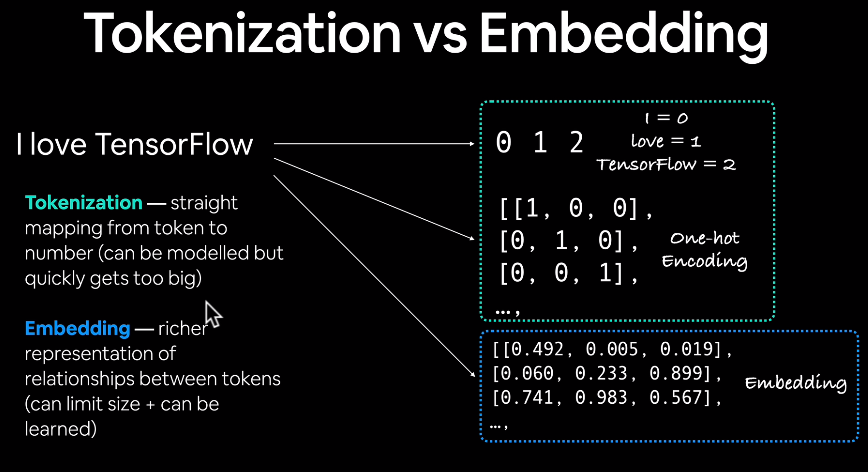